In [10]:
import os
import matplotlib.pyplot as plt
from keras import layers
from keras import models
from keras import optimizers

%matplotlib inline

path_kaggle=os.path.join('w:\\','Documents','kaggle','cats_vs_dogs')
print(path_kaggle)

w:\Documents\kaggle\cats_vs_dogs


In [2]:
from random import shuffle
from collections import defaultdict
import shutil
import pathlib

def load_train_data(path_dest,data_split_type,limit_per_class):
    return_dict={d:defaultdict(list) for d in data_split_type}
    is_already_there=False
    for d in data_split_type:
        if not os.path.exists(os.path.join(path_dest,d)):
            is_already_there=False
            return
        
        if len(os.listdir(os.path.join(path_dest,d)))>0:
            is_already_there=True
            print('Files aready copied to',os.path.join(path_dest,d))
            for root, subdirs, files_indir in os.walk(os.path.join(path_dest,d)):
                if not subdirs:
                    path = os.path.normpath(root)
                    file_class=path.split(os.sep)[-1]
                    shuffle(files_indir)
                    for file_name in files_indir:
                        file_name_as_list=file_name.split('.')
                        if len(file_name_as_list)==3:
                            return_dict[d][file_class].extend([os.path.join(path_dest,d,file_class,file_name)])

    for k_type,k_type_dict in return_dict.items():
        for k,v in k_type_dict.items():
            print('Loaded previously selected',k_type,k,'files -> ',len(v))
            assert limit_per_class[k_type]==len(v)

    return return_dict if is_already_there else None

def split_train_data(path_in,path_out,limit_per_class):    
    path_source=os.path.join(path_kaggle,path_in)
    path_dest=os.path.join(path_kaggle,path_out)
    data_split_type=['train','test','validate']
    return_dict={d:defaultdict(list) for d in data_split_type}

    load_train_data_result=load_train_data(path_dest,data_split_type,limit_per_class)    
    if load_train_data_result:
        return load_train_data_result
    
    files=[]
    for root, subdirs, files_indir in os.walk(path_source):
        print('root = ' , root," files=",len(os.listdir(root)))
        for file in files_indir:
            if pathlib.Path(os.path.join(root,file)).suffix.lower()=='.jpg':
                files.extend([os.path.join(root,file)])
    
    shuffle(files)
    for file_index, file_name in enumerate(files):
        file_name_as_list=os.path.basename(file_name).split('.')
        if len(file_name_as_list)==3:
            file_class=file_name_as_list[0]
            isUsed=False
            for d in data_split_type:                    
                if len(return_dict[d][file_class])<limit_per_class[d] and not isUsed:
                    return_dict[d][file_class].extend([os.path.join(root,file_name)])
                    isUsed=True
                else:continue
    
    for k_type,k_type_dict in return_dict.items():
        for k,v in k_type_dict.items():
            print('Copying',len(v),'randomly',k,'selected','files','to',os.path.join(path_dest,k_type,k))
            os.makedirs(os.path.join(path_dest,k_type,k), exist_ok=True)
            for file in v:
                shutil.copy(file,os.path.join(path_dest,k_type,k,os.path.basename(file)))
    return return_dict


result=split_train_data(os.path.join('original','train'),'solution',
                        limit_per_class={'train':1000,'test':500,'validate':500,'classes':2});

Files aready copied to w:\Documents\kaggle\cats_vs_dogs\solution\train
Files aready copied to w:\Documents\kaggle\cats_vs_dogs\solution\test
Files aready copied to w:\Documents\kaggle\cats_vs_dogs\solution\validate
Loaded previously selected train cat files ->  1000
Loaded previously selected train dog files ->  1000
Loaded previously selected test cat files ->  500
Loaded previously selected test dog files ->  500
Loaded previously selected validate cat files ->  500
Loaded previously selected validate dog files ->  500


In [3]:
from keras.preprocessing.image import ImageDataGenerator
def load_train_data_combine(classes_dict):
    pass

train_datagen = ImageDataGenerator(rescale=1./255)
validate_datagen = ImageDataGenerator(rescale=1./255)

train_generator=train_datagen.flow_from_directory(directory=os.path.join(path_kaggle,'solution','train')
                                        ,target_size=(150, 150)
                                        ,batch_size=20
                                        ,class_mode='binary')

validate_generator=validate_datagen.flow_from_directory(directory=os.path.join(path_kaggle,'solution','validate')
                                        ,target_size=(150, 150)
                                        ,batch_size=20
                                        ,class_mode='binary')

w:\dev\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [7]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

model.compile(loss='binary_crossentropy',
            optimizer=optimizers.RMSprop(lr=1e-4),
            metrics=['acc'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)       147584    
__________

In [8]:
#Time per epoch: CPU=2 minutes, GPU=8 seconds
history = model.fit_generator(
                            train_generator,
                            steps_per_epoch=100,
                            epochs=10,
                            validation_data=validate_generator,
                            validation_steps=50)

Epoch 1/10
100/100 [==============================] - 20s 201ms/step - loss: 0.6885 - acc: 0.5350 - val_loss: 0.6923 - val_acc: 0.5030
Epoch 2/10
100/100 [==============================] - 8s 80ms/step - loss: 0.6612 - acc: 0.6000 - val_loss: 0.6828 - val_acc: 0.5470
Epoch 3/10
100/100 [==============================] - 8s 80ms/step - loss: 0.6268 - acc: 0.6490 - val_loss: 0.6246 - val_acc: 0.6290
Epoch 4/10
100/100 [==============================] - 8s 80ms/step - loss: 0.5906 - acc: 0.6770 - val_loss: 0.6492 - val_acc: 0.6310
Epoch 5/10
100/100 [==============================] - 8s 80ms/step - loss: 0.5653 - acc: 0.7085 - val_loss: 0.5853 - val_acc: 0.6970
Epoch 6/10
100/100 [==============================] - 8s 80ms/step - loss: 0.5256 - acc: 0.7410 - val_loss: 0.5674 - val_acc: 0.6880
Epoch 7/10
100/100 [==============================] - 8s 80ms/step - loss: 0.4979 - acc: 0.7600 - val_loss: 0.5735 - val_acc: 0.6900
Epoch 8/10
100/100 [==============================] - 8s 80ms/step 

In [24]:
model.save(os.path.join(path_kaggle,'solution','models','cats_and_dogs_small_1.h5'))

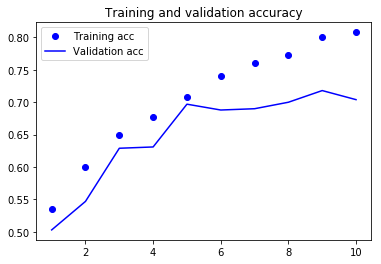

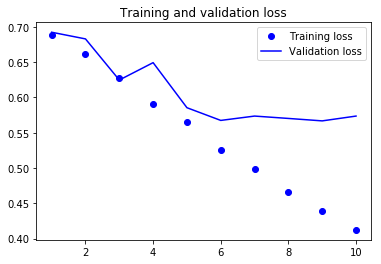

In [9]:
def plot_train_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()
plot_train_history(history)

# Image Augmentation
#### Displaying some randomly augmented training images

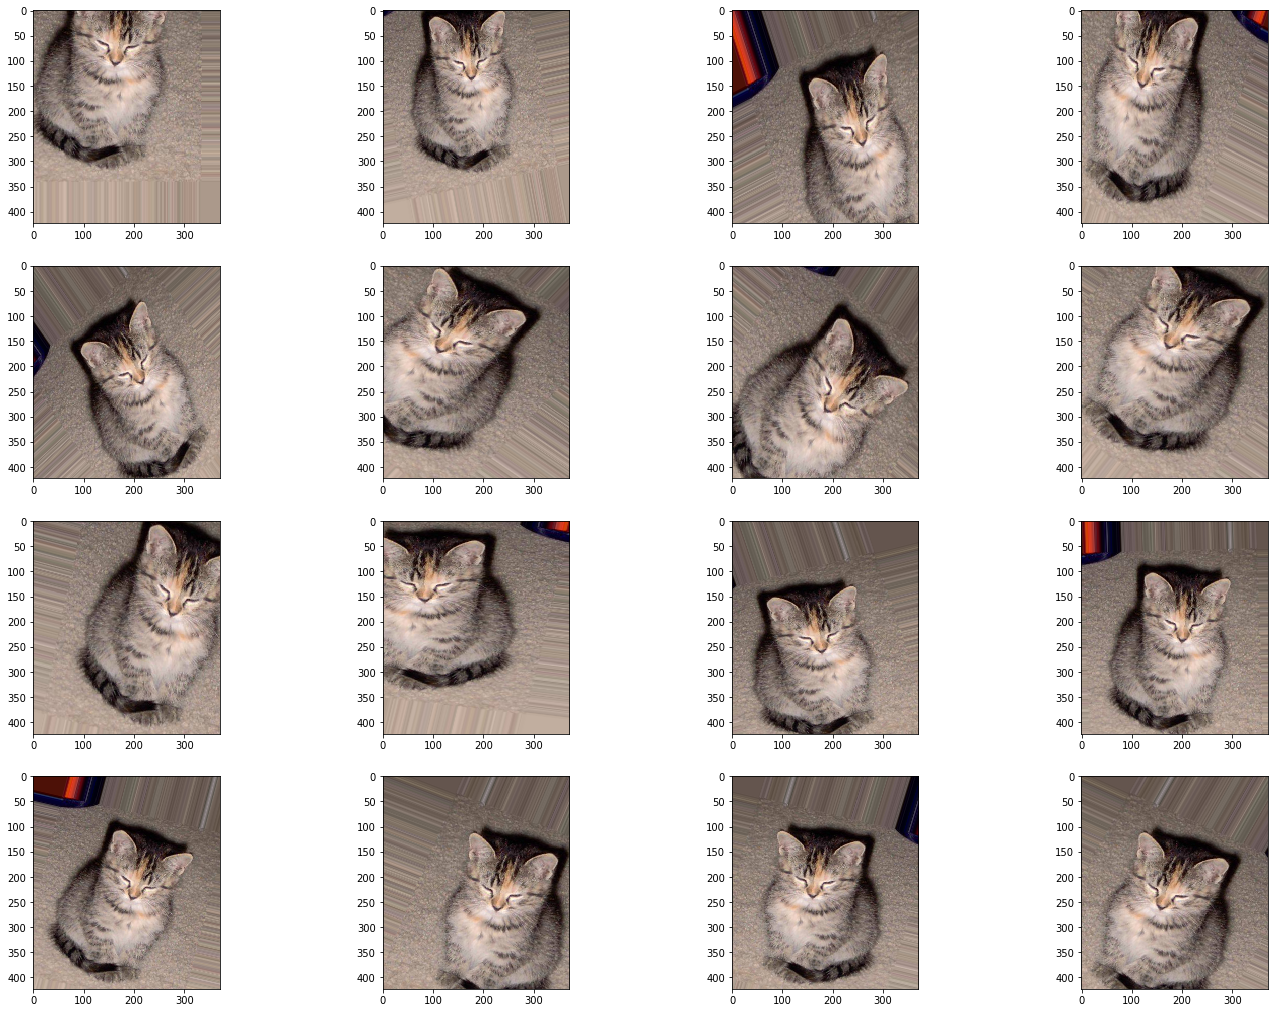

In [6]:
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

from keras.preprocessing import image
import math

img=image.load_img(result['train']['cat'][666])
img=image.img_to_array(img)
img=img.reshape((1,)+img.shape)

dpi_multiplier=2
fig = plt.figure(figsize=(12*dpi_multiplier,9*dpi_multiplier))
how_many=16
for (i,batch) in enumerate(datagen.flow(img,batch_size=1)):
    fig.add_subplot(math.ceil(math.sqrt(how_many)),math.ceil(math.sqrt(how_many)),i+1)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    if i==how_many-1:break

plt.show()

In [11]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5)) #Added a dropout to reduce overfitting with the augmented images
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
    optimizer=optimizers.RMSprop(lr=1e-4),
    metrics=['acc'])

In [12]:
train_datagen = ImageDataGenerator(
                            rescale=1./255,
                            rotation_range=40,
                            width_shift_range=0.2,
                            height_shift_range=0.2,
                            shear_range=0.2,
                            zoom_range=0.2,
                            horizontal_flip=True,)
test_datagen = ImageDataGenerator(rescale=1./255) #No messing with the test dataset

train_generator = train_datagen.flow_from_directory(
                                directory=os.path.join(path_kaggle,'solution','train'),
                                target_size=(150, 150),
                                batch_size=32,
                                class_mode='binary')
validation_generator = test_datagen.flow_from_directory(
                                    directory=os.path.join(path_kaggle,'solution','validate'),
                                    target_size=(150, 150),
                                    batch_size=32,
                                    class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


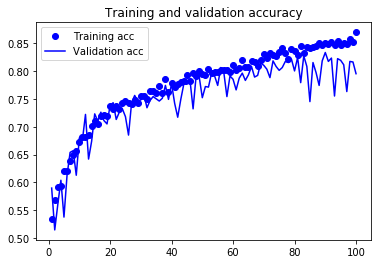

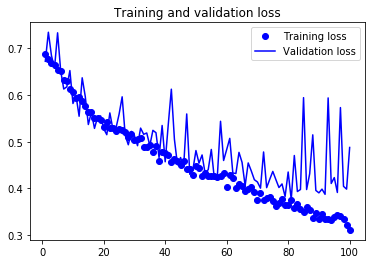

In [15]:
history = model.fit_generator(
                        train_generator,
                        steps_per_epoch=100,
                        epochs=100,
                        validation_data=validation_generator,
                        validation_steps=50)
plot_train_history(history)

In [16]:
model.save(os.path.join(path_kaggle,'solution','models','cats_and_dogs_small_augmented.h5'))

# Reusing convolutional bases

## Feature Extraction with no Data Augmentation (fast)

In [136]:
from keras.applications import VGG16

conv_base_of_VGG16 = VGG16(weights='imagenet',
                include_top=False,
                input_shape=(150, 150, 3))
conv_base_of_VGG16.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

### Create prodictions using the more generalised VGG16 convolution base

In [220]:
# The most difficult thing is keeping the track of the tensros dimesnsions
import numpy as np


def create_inputs_from_other_model(directory,batch_size,conv_base,total_samples):
    datagen = ImageDataGenerator(rescale=1./255)
    generator = datagen.flow_from_directory(
                directory,
                target_size=(150, 150),
                batch_size=batch_size,
                class_mode='binary')
    
     #This convolution base surface layer has shape (4,4,512) (look summary above)
    shape_of_inputs=list(conv_base.layers[-1].output_shape)
    elements_per_input=np.prod(np.array(shape_of_inputs[1:])) 
    print('The parent model requires inputs (none is for the samples) ->',shape_of_inputs,
          'total input elements',elements_per_input)
    print('Loading from',directory)
    for (i,(batch_inputs,batch_labels)) in enumerate(generator):
        predictions=conv_base.predict(batch_inputs)
        if i==0:
            features=predictions
            labels=batch_labels
        else:
            features=np.append(features,predictions,axis=0)
            labels=np.append(labels,batch_labels,axis=0)
        
        if i*batch_size>=total_samples:
            break
            
    total_samples=features.shape[0]
    
    return np.reshape(features, (total_samples, elements_per_input)), labels

train_features,train_labels=create_inputs_from_other_model(directory=os.path.join(path_kaggle,'solution','train')
                                                           ,batch_size=20
                                                           ,total_samples=20
                                                           ,conv_base=conv_base_of_VGG16);

test_features,test_labels=create_inputs_from_other_model(directory=os.path.join(path_kaggle,'solution','test')
                                                           ,batch_size=20
                                                           ,total_samples=20
                                                           ,conv_base=conv_base_of_VGG16);

validate_features,validate_labels=create_inputs_from_other_model(directory=os.path.join(path_kaggle,'solution','validate')
                                                           ,batch_size=20
                                                           ,total_samples=20
                                                           ,conv_base=conv_base_of_VGG16);

Found 2000 images belonging to 2 classes.
The parent model requires inputs (none is for the samples) -> [None, 4, 4, 512] total input elements 8192
Loading from w:\Documents\kaggle\cats_vs_dogs\solution\train
Found 1000 images belonging to 2 classes.
The parent model requires inputs (none is for the samples) -> [None, 4, 4, 512] total input elements 8192
Loading from w:\Documents\kaggle\cats_vs_dogs\solution\test
Found 1000 images belonging to 2 classes.
The parent model requires inputs (none is for the samples) -> [None, 4, 4, 512] total input elements 8192
Loading from w:\Documents\kaggle\cats_vs_dogs\solution\validate


Train on 40 samples, validate on 40 samples
Epoch 1/30
40/40 [==============================] - 1s 17ms/step - loss: 1.0721 - acc: 0.4500 - val_loss: 0.7627 - val_acc: 0.4750
Epoch 2/30
40/40 [==============================] - 0s 650us/step - loss: 0.8299 - acc: 0.4750 - val_loss: 0.7048 - val_acc: 0.5250
Epoch 3/30
40/40 [==============================] - 0s 750us/step - loss: 0.8272 - acc: 0.4250 - val_loss: 0.6924 - val_acc: 0.5500
Epoch 4/30
40/40 [==============================] - 0s 625us/step - loss: 0.7643 - acc: 0.6000 - val_loss: 0.6753 - val_acc: 0.6000
Epoch 5/30
40/40 [==============================] - 0s 625us/step - loss: 0.6231 - acc: 0.5750 - val_loss: 0.6653 - val_acc: 0.6500
Epoch 6/30
40/40 [==============================] - 0s 650us/step - loss: 0.8136 - acc: 0.5000 - val_loss: 0.6470 - val_acc: 0.6250
Epoch 7/30
40/40 [==============================] - 0s 625us/step - loss: 0.5674 - acc: 0.7500 - val_loss: 0.6608 - val_acc: 0.6750
Epoch 8/30
40/40 [===============

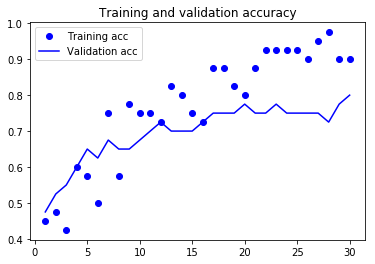

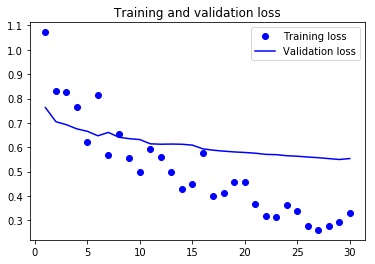

In [223]:
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
        loss='binary_crossentropy',
        metrics=['acc'])

history = model.fit(train_features, train_labels,
                epochs=30,
                batch_size=20,
                validation_data=(validate_features, validate_labels))
plot_train_history(history)

## Feature Extraction with  Data Augmentation (slow)

In [229]:
from keras import models
from keras import layers
model = models.Sequential()
model.add(conv_base_of_VGG16)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 256)               2097408   
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [230]:
 print('This is the number of trainable weights '
'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30


In [233]:
conv_base_of_VGG16.trainable = False

In [234]:
print('This is the number of trainable weights '
'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


In [235]:
model.compile(loss='binary_crossentropy',
            optimizer=optimizers.RMSprop(lr=2e-5),
            metrics=['acc'])

In [236]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest') #Augmented data generetor

test_datagen = ImageDataGenerator(rescale=1./255) #Plain data generetor

train_generator = train_datagen.flow_from_directory(
                                                os.path.join(path_kaggle,'solution','train'),
                                                target_size=(150, 150),
                                                batch_size=20,
                                                class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
                                                os.path.join(path_kaggle,'solution','validate'),
                                                target_size=(150, 150),
                                                batch_size=20,
                                                class_mode='binary')
model.compile(loss='binary_crossentropy',
            optimizer=optimizers.RMSprop(lr=2e-5),
            metrics=['acc'])

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Epoch 1/30
100/100 [==============================] - 33s 330ms/step - loss: 0.5965 - acc: 0.6870 - val_loss: 0.4707 - val_acc: 0.7930
Epoch 2/30
100/100 [==============================] - 32s 321ms/step - loss: 0.4741 - acc: 0.7885 - val_loss: 0.4465 - val_acc: 0.7990
Epoch 3/30
100/100 [==============================] - 32s 319ms/step - loss: 0.4392 - acc: 0.8050 - val_loss: 0.3635 - val_acc: 0.8360
Epoch 4/30
100/100 [==============================] - 32s 318ms/step - loss: 0.4078 - acc: 0.8155 - val_loss: 0.3446 - val_acc: 0.8450
Epoch 5/30
100/100 [==============================] - 32s 319ms/step - loss: 0.3902 - acc: 0.8320 - val_loss: 0.3386 - val_acc: 0.8520
Epoch 6/30
100/100 [==============================] - 32s 319ms/step - loss: 0.3706 - acc: 0.8420 - val_loss: 0.3301 - val_acc: 0.8530
Epoch 7/30
100/100 [==============================] - 32s 321ms/step - loss: 0.3578 - acc: 0.8445 - val_loss: 0.3186 - val_acc: 0.8630
Epoch 8/30
100/100 [==============================] - 3

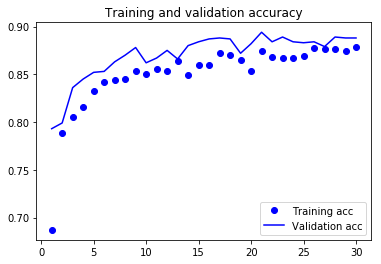

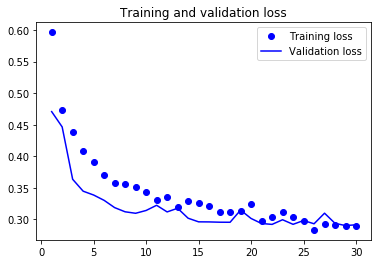

In [237]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch=100,
        epochs=30,
        validation_data=validation_generator,
        validation_steps=50)
plot_train_history(history)